In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes import jtplot

#something for converting datetime for x axis
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
register_matplotlib_converters()
import math
import seaborn as sns
#jtplot.style()
#jtplot.reset()

In [2]:
# PLOT COLORS
cconfirmed = '#d10f0f'
cdeaths="#333232"
crecovered = "#0c91f0"

In [3]:
### lists and dicts to help clear dataframes
#list of columns i want to keep
const_cols = ["Province/State", "Country", "Country/Region", "Date last updated", "Last Update", "Confirmed", "Recovered", "Deaths"]
#dict of column names to change
column_names = {"Country": "Country/Region", "Date last updated": "Last Update"}
#dict of columns and values to put in NaNs
fillna_values = {'Province/State': "", "Country/Region": "", "Confirmed": 0, "Recovered": 0, "Deaths":0}

In [4]:
def read_time_series_csv(url):
    
    df_ts = pd.read_csv(url)
    
    df_ts = df_ts.dropna(axis=0, how='all')
    df_ts = df_ts.dropna(axis=1, how='all')

    df_text = df_ts[df_ts.columns[0:2]]
    df_text = df_text.fillna(value = '')
    
    df_val = df_ts[df_ts.columns[2:len(df_ts.columns)]]
    df_val = df_val.fillna(value = 0)
    
    df_ts = pd.concat([df_text,df_val],axis=1)

    return df_ts

In [5]:
def save_one_file(df_confirmed, df_deaths, df_recovered, file_name):
    with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
        df_confirmed.to_excel(writer, sheet_name='Confirmed')
        df_deaths.to_excel(writer, sheet_name='Deaths')
        df_recovered.to_excel(writer, sheet_name='Recovered')

In [6]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [7]:
df_confirmed = read_time_series_csv(url_confirmed)
df_deaths = read_time_series_csv(url_deaths)
df_recovered = read_time_series_csv(url_recovered)

In [8]:
save_one_file(df_confirmed, df_deaths, df_recovered, "TimeSeries.xlsx")

In [9]:
df_confirmed_gb = df_confirmed.groupby('Country/Region').sum()
df_deaths_gb = df_deaths.groupby('Country/Region').sum()
df_recovered_gb = df_recovered.groupby('Country/Region').sum()

df_confirmed_gb = df_confirmed_gb.reset_index()
df_deaths_gb = df_deaths_gb.reset_index()
df_recovered_gb = df_recovered_gb.reset_index()

save_one_file(df_confirmed_gb, df_deaths_gb, df_recovered_gb, "CasesByCountry.xlsx")

In [10]:
print("Shape of df_confirmed: {}".format(df_confirmed_gb.shape))
print("Shape of df_deaths: {}".format(df_deaths_gb.shape))
print("Shape of df_recovered: {}".format(df_recovered_gb.shape))

#printing whole df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_confirmed)

Shape of df_confirmed: (166, 63)
Shape of df_deaths: (166, 63)
Shape of df_recovered: (166, 63)


In [11]:
confirmed_countries = []
for col in df_confirmed_gb.iloc[:,3:].columns:
    s = df_confirmed_gb.apply(lambda x: True if x[col] > 0 else False , axis=1)
    numOfRows = len(s[s == True].index)
    confirmed_countries.append(numOfRows)
#     print('Number of countries with at least 1 confirmed case on {}: {} '.format(col,numOfRows))
print(confirmed_countries)

[6, 8, 9, 11, 13, 16, 16, 18, 20, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 31, 31, 31, 36, 40, 47, 51, 57, 61, 66, 73, 77, 81, 84, 93, 95, 100, 103, 106, 112, 114, 120, 134, 139, 144, 147, 151, 155, 162, 166]


In [12]:
deaths_countries = []
for col in df_deaths_gb.iloc[:,3:].columns:
    s = df_deaths_gb.apply(lambda x: True if x[col] > 0 else False , axis=1)
    numOfRows = len(s[s == True].index)
    deaths_countries.append(numOfRows)
#     print('Number of countries with at least 1 confirmed case on {}: {} '.format(col,numOfRows))
print(deaths_countries)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 5, 5, 5, 6, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 12, 12, 14, 15, 17, 18, 18, 20, 22, 24, 33, 37, 40, 45, 47, 49, 55, 60, 67, 71, 80]


In [13]:
china_confirmed = df_confirmed_gb[df_confirmed_gb['Country/Region']=="China"].iloc[:,3:]
china_deaths = df_deaths_gb[df_deaths_gb['Country/Region']=="China"].iloc[:,3:]
china_recovered = df_recovered_gb[df_recovered_gb['Country/Region']=="China"].iloc[:,3:]

# china_confirmed = df_confirmed[df_confirmed['Country/Region']=="China"].iloc[:,4:].sum(axis=0)
# china_deaths = df_deaths[df_deaths['Country/Region']=="China"].iloc[:,4:].sum(axis=0)
# china_recovered = df_recovered[df_recovered['Country/Region']=="China"].iloc[:,4:].sum(axis=0)

china_confirmed = china_confirmed.transpose()
china_deaths = china_deaths.transpose()
china_recovered = china_recovered.transpose()

In [14]:
dates = china_confirmed.index.values
print(dates)

dates = pd.to_datetime(dates, infer_datetime_format=True)

print(dates)

['1/22/20' '1/23/20' '1/24/20' '1/25/20' '1/26/20' '1/27/20' '1/28/20'
 '1/29/20' '1/30/20' '1/31/20' '2/1/20' '2/2/20' '2/3/20' '2/4/20'
 '2/5/20' '2/6/20' '2/7/20' '2/8/20' '2/9/20' '2/10/20' '2/11/20'
 '2/12/20' '2/13/20' '2/14/20' '2/15/20' '2/16/20' '2/17/20' '2/18/20'
 '2/19/20' '2/20/20' '2/21/20' '2/22/20' '2/23/20' '2/24/20' '2/25/20'
 '2/26/20' '2/27/20' '2/28/20' '2/29/20' '3/1/20' '3/2/20' '3/3/20'
 '3/4/20' '3/5/20' '3/6/20' '3/7/20' '3/8/20' '3/9/20' '3/10/20' '3/11/20'
 '3/12/20' '3/13/20' '3/14/20' '3/15/20' '3/16/20' '3/17/20' '3/18/20'
 '3/19/20' '3/20/20' '3/21/20']
DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-1

In [15]:
sns.set()
#sns.axes_style()

In [16]:
sns.set(style = {'axes.edgecolor': 'black',
                 'grid.color': 'white',
                 'axes.facecolor': '#f5f1df',
                 'xtick.bottom': True,
                'ytick.left': True})

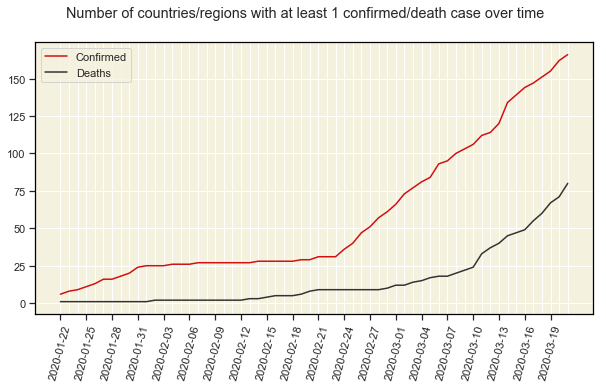

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(dates,confirmed_countries, color = cconfirmed)
ax.plot(dates,deaths_countries, color = cdeaths)
plt.xticks(rotation=75)
ax.legend(['Confirmed', 'Deaths'])
fig.suptitle('Number of countries/regions with at least 1 confirmed/death case over time')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/num_of_countries.png",bbox_inches='tight')

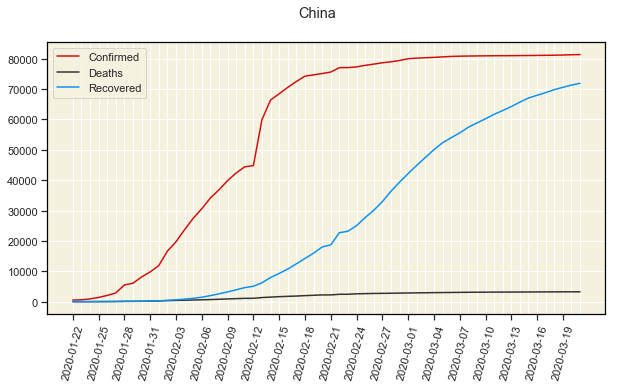

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(dates, china_confirmed, color = cconfirmed)
ax.plot(dates, china_deaths, color = cdeaths)
ax.plot(dates, china_recovered, color = crecovered)
plt.xticks(rotation=75)
ax.legend(['Confirmed', 'Deaths', 'Recovered'])
fig.suptitle('China')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/china.png",bbox_inches='tight')

In [19]:
italy_confirmed = df_confirmed_gb[df_confirmed_gb['Country/Region']=="Italy"].iloc[:,3:]
italy_deaths = df_deaths_gb[df_deaths_gb['Country/Region']=="Italy"].iloc[:,3:]
italy_recovered = df_recovered_gb[df_recovered_gb['Country/Region']=="Italy"].iloc[:,3:]

# china_confirmed = df_confirmed[df_confirmed['Country/Region']=="China"].iloc[:,4:].sum(axis=0)
# china_deaths = df_deaths[df_deaths['Country/Region']=="China"].iloc[:,4:].sum(axis=0)
# china_recovered = df_recovered[df_recovered['Country/Region']=="China"].iloc[:,4:].sum(axis=0)

italy_confirmed = italy_confirmed.transpose()
italy_deaths = italy_deaths.transpose()
italy_recovered = italy_recovered.transpose()

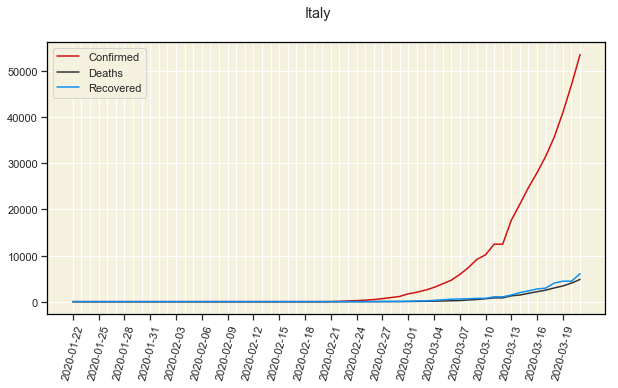

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(dates, italy_confirmed, color = cconfirmed)
ax.plot(dates, italy_deaths, color=cdeaths)
ax.plot(dates, italy_recovered, color = crecovered)
plt.xticks(rotation=75)
ax.legend(['Confirmed', 'Deaths', 'Recovered'])
fig.suptitle('Italy')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/italy.png",bbox_inches='tight')

In [21]:
# countries = df_confirmed['Country/Region'].unique()
countries = df_confirmed_gb['Country/Region'].unique()
print("Number of countries with at least 1 confirmed case: {}".format(len(countries)))
#print(countries)

Number of countries with at least 1 confirmed case: 166


In [22]:
#list of number of confirmed cases from last column
    
confirmed_country = df_confirmed_gb.iloc[:,-1].tolist()

cc_sort = confirmed_country.copy()
cc_sort.sort()
print("Sorted number of confirmed cases: {}".format(cc_sort))

Sorted number of confirmed cases: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 6, 6, 6, 7, 7, 7, 9, 10, 11, 13, 14, 14, 14, 14, 16, 16, 17, 17, 18, 19, 19, 21, 22, 23, 24, 24, 25, 27, 32, 37, 43, 47, 47, 49, 49, 52, 52, 53, 53, 53, 60, 64, 70, 73, 76, 76, 77, 80, 83, 83, 84, 85, 85, 88, 93, 94, 96, 103, 110, 112, 117, 124, 139, 144, 153, 153, 158, 160, 163, 171, 176, 178, 187, 196, 200, 203, 206, 214, 240, 294, 305, 306, 306, 307, 318, 330, 367, 383, 392, 411, 432, 450, 473, 481, 506, 523, 530, 536, 537, 670, 670, 712, 730, 785, 883, 995, 1007, 1021, 1071, 1183, 1278, 1280, 1420, 1763, 2118, 2814, 2815, 3640, 5067, 6575, 8799, 14431, 20610, 22213, 25374, 25489, 53578, 81305]


In [23]:
#print(dates)

In [24]:
# I am not using it anymore
def multi_plot_limits(png_name):
    
    dictionary = {"Country": countries ,"Confirmed": confirmed_country}
    countries_last_date = pd.DataFrame(dictionary)
    in_limits = countries_last_date.apply(lambda x: False if x['Confirmed'] < limit_low else (False if x['Confirmed'] > limit_high else True), axis=1)
    # print(in_limits)
    how_many = len(in_limits[in_limits == True].index)
    print('Number of countries with number of confirmed cases between {} and {}: {}'.format(limit_low,limit_high, how_many))
    
    
    indexTrue = in_limits[ in_limits == False ].index.tolist()
    indexFalse = in_limits[ in_limits == True ].index.tolist()
    # #copying to not change original df
    countries_in_limits = countries_last_date.copy()
    countries_in_limits.drop(indexTrue, inplace=True, axis=0)
    
    
    #define how many rows on how many countries in list without china
    plots_in_col = math.ceil((how_many)/plots_in_row)

    fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
    fig.autofmt_xdate(rotation = 65)  
    axs0 = axs.shape[0]
    axs1 = axs.shape[1]

    i = 0
    j = 0
    
    date_fmt = mdates.DateFormatter('%Y-%m-%d')
    
    for country in countries_in_limits["Country"]:
        axs[i][j].plot(dates, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = cconfirmed)
        axs[i][j].plot(dates, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = cdeaths)
        axs[i][j].plot(dates, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = crecovered)
        axs[i][j].set_title(country)
        #axs[i][j].set_xticklabels(rotation=75)

        every_nth = 5
        dates.freq = 'd'
        list_dates = []
        for d in range(len(dates)):
            if d % every_nth == 0:
                list_dates.append(dates[d])
        
        axs[i][j].set_xticks(list_dates)
        axs[i][j].xaxis.set_major_formatter(date_fmt)
#         for n, label in enumerate(axs[i][j].xaxis.get_ticklabels()):
#             if n % every_nth != 0:
#                 label.set_visible(False)

#         for n, line in enumerate(axs[i][j].xaxis.get_ticklines()):
#             if n % every_nth != 0:
#                 line.set_visible(False)
    
        i = i + 1
        if i==plots_in_col:
            i = 0
            j = j + 1
            if j==plots_in_row:
                j = 0
              
    fig.suptitle('Countries with number of confirmed cases between {} and {}'.format(limit_low, limit_high))
    fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0.11, 0., 0., 1.),bbox_transform=plt.gcf().transFigure)
    plt.savefig(png_name,bbox_inches='tight')

In [25]:
df_nlargest = df_confirmed_gb.nlargest(11,df_confirmed_gb.columns[-1])
df_nsmallest = df_nlargest.nsmallest(9, df_nlargest.columns[-1])
df_multiplot_confirmed = df_nsmallest.nlargest(9, df_nsmallest.columns[-1])
df_multiplot_deaths = df_deaths_gb[df_deaths_gb['Country/Region'].isin(df_multiplot_confirmed['Country/Region'].tolist())]
df_multiplot_recovered = df_recovered_gb[df_recovered_gb['Country/Region'].isin(df_multiplot_confirmed['Country/Region'].tolist())]

In [26]:
def multi_plot(png_name):
    
    plots_in_row = 3
    plots_in_col = 3

    fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
    fig.autofmt_xdate(rotation = 65)  
    axs0 = axs.shape[0]
    axs1 = axs.shape[1]

    i = 0
    j = 0
    
    date_fmt = mdates.DateFormatter('%Y-%m-%d')
    
    
    for country in df_multiplot_confirmed['Country/Region']:
        axs[i][j].plot(dates, df_multiplot_confirmed[df_multiplot_confirmed['Country/Region']==country].iloc[0,3:].tolist(), color = cconfirmed)
        axs[i][j].plot(dates, df_multiplot_deaths[df_multiplot_deaths['Country/Region']==country].iloc[0,3:].tolist(), color = cdeaths)
        axs[i][j].plot(dates, df_multiplot_recovered[df_multiplot_recovered['Country/Region']==country].iloc[0,3:].tolist(), color = crecovered)
        axs[i][j].set_title(country, size = 'large')
        #axs[i][j].set_xticklabels(rotation=75)

        every_nth = 5
        dates.freq = 'd'
        list_dates = []
        for d in range(len(dates)):
            if d % every_nth == 0:
                list_dates.append(dates[d])
        
        axs[i][j].set_xticks(list_dates)
        axs[i][j].xaxis.set_major_formatter(date_fmt)
#         for n, label in enumerate(axs[i][j].xaxis.get_ticklabels()):
#             if n % every_nth != 0:
#                 label.set_visible(False)

#         for n, line in enumerate(axs[i][j].xaxis.get_ticklines()):
#             if n % every_nth != 0:
#                 line.set_visible(False)
    
        i = i + 1
        if i==plots_in_col:
            i = 0
            j = j + 1
            if j==plots_in_row:
                j = 0
              
    fig.suptitle('9 countries with most confirmed cases (without China nad Italy)',size='xx-large')
    fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0.11, 0., 0., 1.),bbox_transform=plt.gcf().transFigure)
    plt.savefig(png_name,bbox_inches='tight')

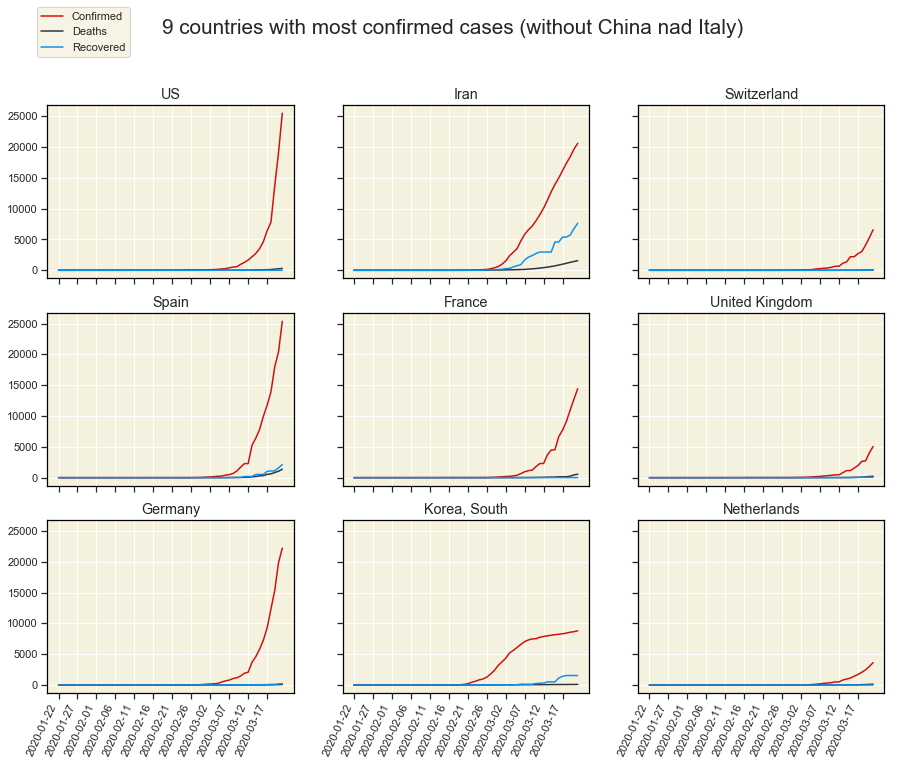

In [27]:
multi_plot('img/most_confirmed_cases.png')

In [28]:
df_confirmed_gb.iloc[:,4:].max().max()

81305

In [29]:
# limit_high = 20000
# limit_low = 5000

In [41]:
# plots_in_row = 3
# multi_plot("img/between_1500_15000.png")

In [31]:
# limit_high = df_confirmed_gb.iloc[:,4:].max().max()
# limit_low = 5000

In [32]:
# plots_in_row = 3
# multi_plot("img/between_limits.png")

In [33]:
def make_df_colCountry_rowValues(df, countries_ts):
    #new df - columns will be countries, index is date
    df_colCountry_rowConfirmed = pd.DataFrame()
    #print(df_colCountry_rowConfirmed)
    for i, country in enumerate(countries_ts,0):
        column = df[df['Country/Region']==country].iloc[:,4:].sum(axis=0)
        df_colCountry_rowConfirmed.insert(i, country, column)
    #print(df_colCountry_rowConfirmed.tail(3))
    return df_colCountry_rowConfirmed

In [34]:
# df_colCountry_rowConfirmed = make_df_colCountry_rowValues(df_confirmed, countries)
# df_colCountry_rowDeaths = make_df_colCountry_rowValues(df_deaths, countries)
# df_colCountry_rowRecovered = make_df_colCountry_rowValues(df_recovered, countries)

In [35]:
#przyrosty względne
# rel_change_confirmed = df_colCountry_rowConfirmed.pct_change()
rel_change_confirmed = df_confirmed_gb.iloc[:,3:].pct_change(axis= 1)
#print(rel_change_confirmed)

In [36]:
abs_change_confirmed = df_confirmed_gb.iloc[:,3:].diff(axis = 1)
abs_change_deaths = df_deaths_gb.iloc[:,3:].diff(axis = 1)
abs_change_recovered = df_recovered_gb.iloc[:,3:].diff(axis = 1)
print(abs_change_confirmed.head(3))

   1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
0      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   1/30/20  1/31/20  ...  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  \
0      0.0      0.0  ...      0.0      0.0      4.0      5.0      5.0   
1      0.0      0.0  ...     11.0     10.0      5.0      4.0      9.0   
2      0.0      0.0  ...      4.0      2.0     11.0     11.0      6.0   

   3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  
0      1.0      0.0      0.0      2.0      0.0  
1      4.0      4.0      5.0      6.0      6.0  
2      6.0     14.0     13.0      3.0     49.0  

[3 rows x 60 columns]


In [37]:
#plt.plot(df_colCountry_rowConfirmed["Mainland China"].diff())

In [38]:
daily_abs_change_confirmed_all = abs_change_confirmed.sum(axis=0)
daily_abs_change_deaths_all = abs_change_deaths.sum(axis=0)
daily_abs_change_recovered_all = abs_change_recovered.sum(axis=0)

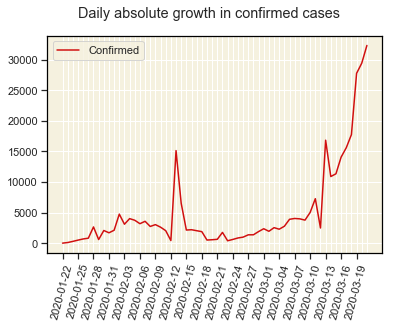

In [39]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(dates, daily_abs_change_confirmed_all, color = cconfirmed)
plt.xticks(rotation=75)
ax.legend(['Confirmed'])
fig.suptitle('Daily absolute growth in confirmed cases')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/abs_growth_confirmed.png",bbox_inches='tight')

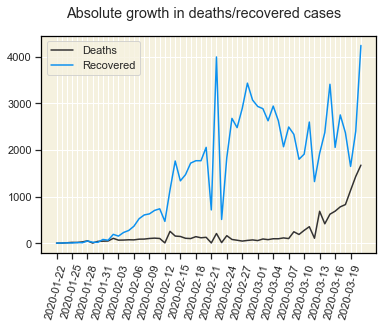

In [40]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(dates, daily_abs_change_deaths_all, color = cdeaths)
ax.plot(dates, daily_abs_change_recovered_all, color = crecovered)
plt.xticks(rotation=75)
ax.legend(['Deaths', 'Recovered'])
fig.suptitle('Absolute growth in deaths/recovered cases')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/abs_growth_deaths_recovered.png",bbox_inches='tight')